In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Q1
## Use of PERMNO vs. TICKERS:

PERMNO is a unique identifier assigned by the Center for Research in Security Prices (CRSP) to each security in the market. It is used in academic and research settings because it provides a consistent way to track securities over time, regardless of changes in ticker symbols, company names, or corporate actions such as mergers and acquisitions. This consistency is crucial for historical analysis over long periods, as it allows for the unambiguous identification of securities.


TICKERS, on the other hand, are symbols assigned to securities traded on public exchanges. These can change over time due to various reasons, such as rebranding, mergers, or moving between exchanges, which can create confusion in longitudinal studies.

The choice of PERMNO over tickers for the dataset is likely aimed at ensuring consistency and accuracy in tracking the performance and characteristics of securities over time, especially in a dataset that spans several years.

# Q2
## Discrepancies between One-Month Price Change and PRC Column:

a. This discrepancy is not data error. The PRC column reflects the total return, and it incorporates the price appreciation/depreciation, dividends, and other distributions paid to investors. Total return is a more comprehensive view of an investment's performance.

The percent changes of price simply reflects the movement in the security's market price. This calculation does not account for dividends or other returns of holding the security. It only focuses on price appreciation/depreciation.


b. For some companies, these values may always match. Because there are no dividends or distributions, or any other corporate actions that might affect the total return.

In [3]:
# Price_Ret(T1)

file_path = 'sp500raw.xlsx'
sp500_data = pd.read_excel(file_path)
sp500_data.drop(columns=['Unnamed: 0'], inplace =True)
sp500_data['date'] = pd.to_datetime(sp500_data['date'])
sp500_data.sort_values(by=['permno', 'date'], inplace=True)

sp500_data['Price_Ret(T1)'] = sp500_data.groupby('permno')['price'].pct_change()


display(sp500_data.head())


,permno,date,price,shrout,prc,mcap,Price_Ret(T1)
48,10104,2011-01-31,32.0300,5052420,0.024920,1.618290e+08,NaN
719,10104,2011-02-28,32.9000,5061000,0.027162,1.665069e+08,0.027162
1100,10104,2011-03-31,33.4325,5060516,0.016185,1.691857e+08,0.016185
1836,10104,2011-04-29,35.9600,5060516,0.077395,1.819762e+08,0.075600
2410,10104,2011-05-31,34.2200,5068000,-0.048387,1.734270e+08,-0.048387


# Q3
## Variability in the Number of Companies:

The number of companies in the S&P 500 index does not always precisely equal 500 due to several factors, including mergers, acquisitions, bankruptcies, and the addition or removal of companies based on the market capitalization criteria set by the index. These events can cause the number of constituents to fluctuate temporarily until adjustments are made.

It's not a mistake but reflects the dynamic nature of the stock market and the index's composition adjustments to maintain its representation of the U.S. economy's leading companies.

# Q4

## 303 companies are present over the entire sample 
## 761 unique companies are in the sample

In [4]:
date_counts = sp500_data.groupby('permno').size()
full_presence_companies = date_counts[date_counts == sp500_data['date'].nunique()]

unique_companies = sp500_data['permno'].nunique()

(full_presence_companies.count(), unique_companies)

(303, 761)

# Q5



First, we plot the time series of market cap for all stocks each month

<Axes: title={'center': 'Different percentile for market cap'}, xlabel='date', ylabel='mcap'>

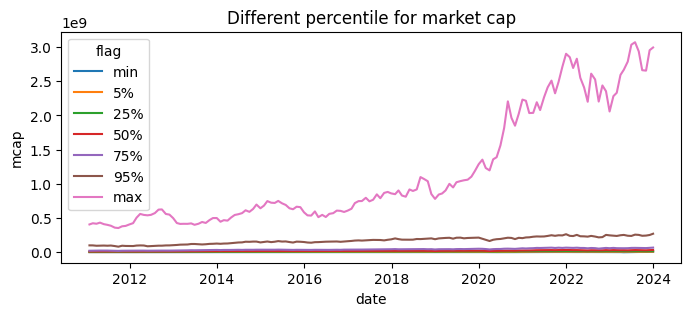

In [5]:
mcap_plot = sp500_data.groupby('date')['mcap'].describe(percentiles=[0.05,0.25,0.75,0.95]).reset_index()

col_plot = ['min', '5%', '25%', '50%', '75%', '95%','max']
df_list = []
for i in col_plot:
    tmp_df = mcap_plot[['date',i]]
    tmp_df['flag'] = i
    tmp_df.rename(columns={i:'mcap'},inplace=True)
    df_list.append(tmp_df)
mcap_final = pd.concat(df_list,axis=0)

plt.figure(figsize=(8,3))
plt.title('Different percentile for market cap')
sns.lineplot(data=mcap_final,x = 'date',y = 'mcap',hue='flag')


### Q5 a
Calculate the percentile range for stock leaving

In [6]:
percentiles=[0.05,0.25,0.75,0.95]

last_dates = sp500_data.groupby('permno')['date'].max()
one_month_prior = last_dates - pd.DateOffset(months=1)

# Step 2: Convert 'one_month_prior' to a DataFrame for merging
one_month_prior_df = one_month_prior.reset_index()
one_month_prior_df.columns = ['permno', 'date']

prior_to_leaving = pd.merge(sp500_data, one_month_prior_df, how='inner', on=['permno', 'date'])
prior_to_leaving['date'] = prior_to_leaving['date'].dt.to_period('M')

# Calculate the quantiles of mcap for all companies on each date
prior_percentiles = prior_to_leaving.groupby('date')['mcap'].quantile(np.array(percentiles)/100).unstack()

# Merge the permno information with the prior_percentiles DataFrame
prior_percentiles = pd.merge(prior_percentiles, prior_to_leaving[['date', 'permno']], on='date')

prior_percentiles

,date,0.0005,0.0025,0.0075,0.0095,permno
0,2011-02,2.085915e+06,2.125769e+06,2.225403e+06,2.265257e+06,10324
1,2011-02,2.085915e+06,2.125769e+06,2.225403e+06,2.265257e+06,85032
2,2011-02,2.085915e+06,2.125769e+06,2.225403e+06,2.265257e+06,90609
3,2011-09,1.122584e+06,1.135910e+06,1.169227e+06,1.182554e+06,12570
4,2011-09,1.122584e+06,1.135910e+06,1.169227e+06,1.182554e+06,88313
...,...,...,...,...,...,...
77,2022-02,4.761020e+06,4.778223e+06,4.821230e+06,4.838433e+06,92778
78,2022-11,4.851052e+06,4.851052e+06,4.851052e+06,4.851052e+06,28388
79,2023-06,4.178913e+06,4.178913e+06,4.178913e+06,4.178913e+06,89217
80,2023-07,4.622538e+06,4.622802e+06,4.623462e+06,4.623726e+06,49015


 ### Q5 b
Calculate the percentile range for stock entering

In [7]:
first_dates = sp500_data.groupby('permno')['date'].min()
first_dates_df = first_dates.reset_index()
first_dates_df.columns = ['permno', 'date']

upon_entering = pd.merge(sp500_data, first_dates_df, how = 'inner', on = ['permno', 'date'])
upon_entering['date'] = upon_entering['date'].dt.to_period('M')

entering_percentiles = upon_entering.groupby('date')['mcap'].quantile(np.array(percentiles)/100).unstack()

entering_percentiles = pd.merge(entering_percentiles, upon_entering[['date', 'permno']], on='date')
entering_percentiles

,date,0.0005,0.0025,0.0075,0.0095,permno
0,2011-01,1.591110e+06,1.730485e+06,1.902694e+06,2.071862e+06,10104
1,2011-01,1.591110e+06,1.730485e+06,1.902694e+06,2.071862e+06,10107
2,2011-01,1.591110e+06,1.730485e+06,1.902694e+06,2.071862e+06,10137
3,2011-01,1.591110e+06,1.730485e+06,1.902694e+06,2.071862e+06,10138
4,2011-01,1.591110e+06,1.730485e+06,1.902694e+06,2.071862e+06,10145
...,...,...,...,...,...,...
756,2023-10,1.448824e+07,1.449828e+07,1.452338e+07,1.453341e+07,24174
757,2023-10,1.448824e+07,1.449828e+07,1.452338e+07,1.453341e+07,32942
758,2023-10,1.448824e+07,1.449828e+07,1.452338e+07,1.453341e+07,92203
759,2023-12,2.064460e+07,2.085683e+07,2.138738e+07,2.159960e+07,18576


### Q5 i-vi


In [8]:
df = sp500_data.copy()
df.set_index('date', inplace=True)
df = df.sort_values(['permno', 'date'])

def geometric_return(returns):
    return np.prod(1+returns) - 1

# Trailing twelve-month return based on prc and price
df['PRC_Ret(T12)'] = df.groupby('permno')['prc'].transform(lambda x: x.rolling(12).apply(geometric_return, raw = True))
df['Prices_Ret(T12)'] = df.groupby('permno')['Price_Ret(T1)'].transform(lambda x: x.rolling(12).apply(geometric_return, raw = True))

# Excluding the most recent month (T12M1)
df['PRC_Ret(T12M1)'] = df.groupby('permno')['prc'].transform(lambda x: x.shift(1).rolling(window=11).apply(geometric_return, raw = True))
df['Prices_Ret(T12M1)'] = df.groupby('permno')['Price_Ret(T1)'].transform(lambda x: x.shift(1).rolling(window=11).apply(geometric_return, raw = True))

# one-month-return from 12 months ago
df['PRC_Ret(T12_1M)'] = df.groupby('permno')['prc'].shift(12)
df['Prices_Ret(T12_1M)'] =  df.groupby('permno')['Price_Ret(T1)'].shift(12)

# standard deviation of the monthly price based returns
df['Vol_Prices_Ret(T12M1)'] = df.groupby('permno')['Price_Ret(T1)'].transform(lambda x: x.shift(1).rolling(window=11).std())
df['SR_Prices_Ret(T12M1)'] = df['Prices_Ret(T12M1)'] / df['Vol_Prices_Ret(T12M1)']

df[df['permno'] == 13688].head(15)

,permno,price,shrout,prc,mcap,Price_Ret(T1),PRC_Ret(T12),Prices_Ret(T12),PRC_Ret(T12M1),Prices_Ret(T12M1),PRC_Ret(T12_1M),Prices_Ret(T12_1M),Vol_Prices_Ret(T12M1),SR_Prices_Ret(T12M1)
date,,,,,,,,,,,,,,
2011-01-31,13688,46.28,392066,-0.032609,18144814.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-28,13688,46.06,396258,-0.004754,18251643.48,-0.004754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-03-31,13688,44.18,396789,-0.030938,17530138.02,-0.040816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-04-29,13688,46.08,396789,0.043006,18284037.12,0.043006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-05-31,13688,43.38,397950,-0.058594,17263071.00,-0.058594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-06-30,13688,42.03,397950,-0.020632,16725838.50,-0.031120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-29,13688,41.43,397950,-0.014276,16487068.50,-0.014276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-31,13688,42.35,402245,0.022206,17035075.75,0.022206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-30,13688,42.30,402245,0.009563,17014963.50,-0.001181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# Calculate 1-month, 3-month, 6-month returns


df['PRC_Ret(F1M)'] = df.groupby('permno')['prc'].shift(-1)
df['PRC_Ret(F3M)'] = df.groupby('permno')['prc'].rolling(3).apply(geometric_return).groupby(level=0).shift(-3).reset_index(level=0, drop=True)
df['PRC_Ret(F3M)'] = df.groupby('permno')['prc'].rolling(6).apply(geometric_return).groupby(level=0).shift(-6).reset_index(level=0, drop=True)

df[df['permno'] == 13688].head(20)


,permno,price,shrout,prc,mcap,Price_Ret(T1),PRC_Ret(T12),Prices_Ret(T12),PRC_Ret(T12M1),Prices_Ret(T12M1),PRC_Ret(T12_1M),Prices_Ret(T12_1M),Vol_Prices_Ret(T12M1),SR_Prices_Ret(T12M1),PRC_Ret(F1M),PRC_Ret(F3M),PRC_Ret(F6M)
date,,,,,,,,,,,,,,,,,
2011-01-31,13688,46.28,392066,-0.032609,18144814.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004754,-0.085788,NaN
2011-02-28,13688,46.06,396258,-0.004754,18251643.48,-0.004754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.030938,-0.061023,NaN
2011-03-31,13688,44.18,396789,-0.030938,17530138.02,-0.040816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043006,-0.021779,NaN
2011-04-29,13688,46.08,396789,0.043006,18284037.12,0.043006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.058594,-0.048810,NaN
2011-05-31,13688,43.38,397950,-0.058594,17263071.00,-0.058594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.020632,-0.085230,NaN
2011-06-30,13688,42.03,397950,-0.020632,16725838.50,-0.031120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.014276,0.002219,0.002219
2011-07-29,13688,41.43,397950,-0.014276,16487068.50,-0.014276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022206,0.002921,0.002921
2011-08-31,13688,42.35,402245,0.022206,17035075.75,0.022206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009563,0.005746,0.005746
2011-09-30,13688,42.30,402245,0.009563,17014963.50,-0.001181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014185,0.048444,0.048444


In [51]:
df[df['permno'] == 13688].tail(20)

,permno,price,shrout,prc,mcap,Price_Ret(T1),PRC_Ret(T12),Prices_Ret(T12),PRC_Ret(T12M1),Prices_Ret(T12M1),PRC_Ret(T12_1M),Prices_Ret(T12_1M),Vol_Prices_Ret(T12M1),SR_Prices_Ret(T12M1),PRC_Ret(F1M),PRC_Ret(F3M),PRC_Ret(F6M)
date,,,,,,,,,,,,,,,,,
2018-08-31,13688,46.18,517151,0.071959,23882033.18,0.071959,-0.338740,-0.343848,-0.383129,-0.387894,0.039740,0.039740,0.073846,-5.252737,-0.003681,-0.354049,-0.354049
2018-09-28,13688,46.01,517151,-0.003681,23794117.51,-0.003681,-0.324276,-0.324277,-0.321780,-0.321780,-0.025007,-0.032538,0.081380,-3.954051,0.017388,-0.328537,-0.328537
2018-10-31,13688,46.81,517151,0.017388,24207838.31,0.017388,-0.189717,-0.189718,-0.203565,-0.203566,-0.151564,-0.151564,0.071131,-2.861863,-0.436445,-0.354625,-0.354625
2018-11-30,13688,26.38,518674,-0.436445,13682620.12,-0.436445,-0.513643,-0.513643,-0.136983,-0.136984,-0.061104,-0.061104,0.070312,-1.948229,-0.099697,0.125019,0.125019
2018-12-31,13688,23.75,518674,-0.099697,12318507.50,-0.099697,-0.470221,-0.470221,-0.411554,-0.411555,-0.173488,-0.173488,0.140641,-2.926289,0.194400,0.293600,0.293600
2022-10-31,13688,14.93,1987700,0.194400,29676361.00,-0.371368,-0.331439,-0.648126,-0.440254,-0.440255,-0.053536,-0.053536,0.141937,-3.101749,0.051574,0.146015,0.146015
2022-11-30,13688,15.70,1987700,0.051574,31206890.00,0.051574,-0.274032,-0.617912,-0.309637,-0.636651,-0.031581,-0.031581,0.173600,-3.667350,0.035669,0.078980,0.078980
2022-12-30,13688,16.26,1987700,0.035669,32320002.00,0.035669,-0.296745,-0.629866,-0.320965,-0.642613,0.069117,0.069117,0.172270,-3.730258,-0.022140,0.062730,0.062730
2023-01-31,13688,15.90,1987700,-0.022140,31604430.00,-0.022140,-0.344685,-0.655098,-0.329848,-0.647289,0.049397,0.049397,0.171354,-3.777486,-0.017610,0.107546,0.107546


# Q6

plot the time series of different variables

In [52]:
var_list = ['Price_Ret(T1)',
            'PRC_Ret(T12)', 'Prices_Ret(T12)', 
            'PRC_Ret(T12M1)', 'Prices_Ret(T12M1)', 
            'PRC_Ret(T12_1M)', 'Prices_Ret(T12_1M)',
            'Vol_Prices_Ret(T12M1)', 'SR_Prices_Ret(T12M1)', 
            'PRC_Ret(F1M)', 'PRC_Ret(F3M)', 'PRC_Ret(F6M)']

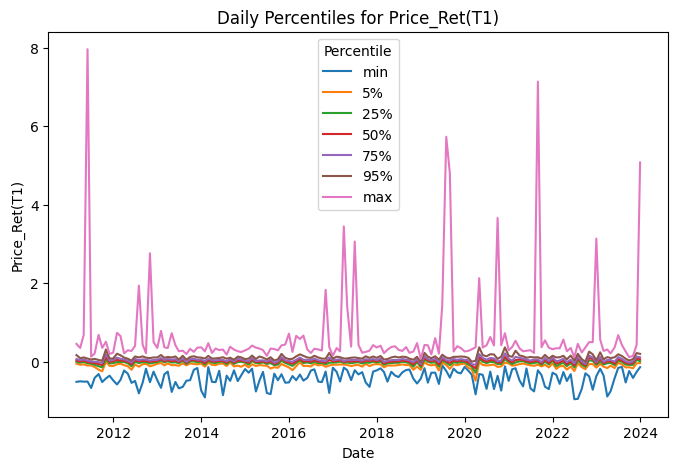

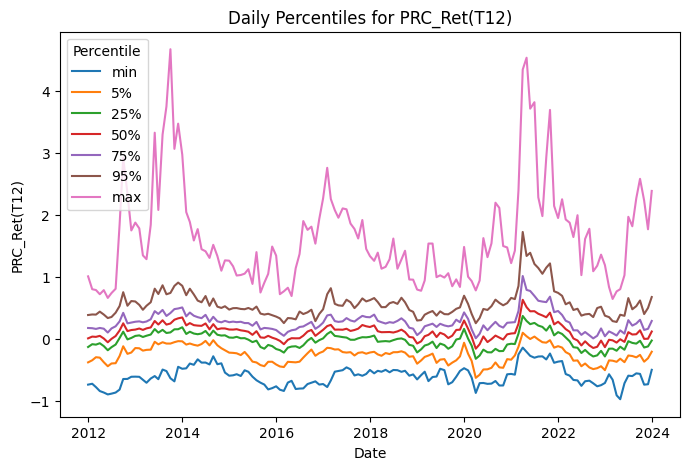

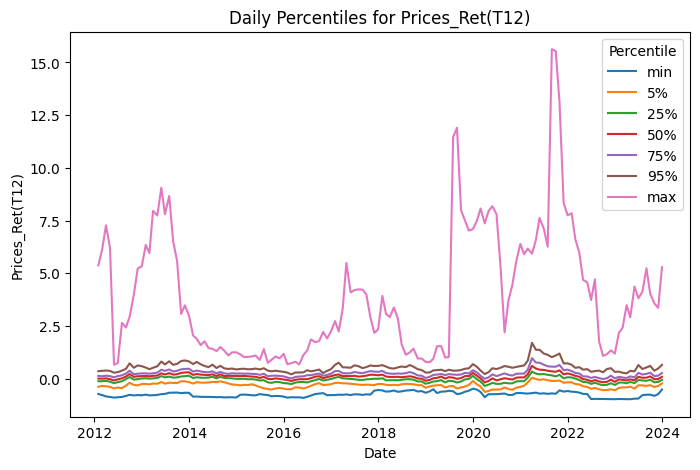

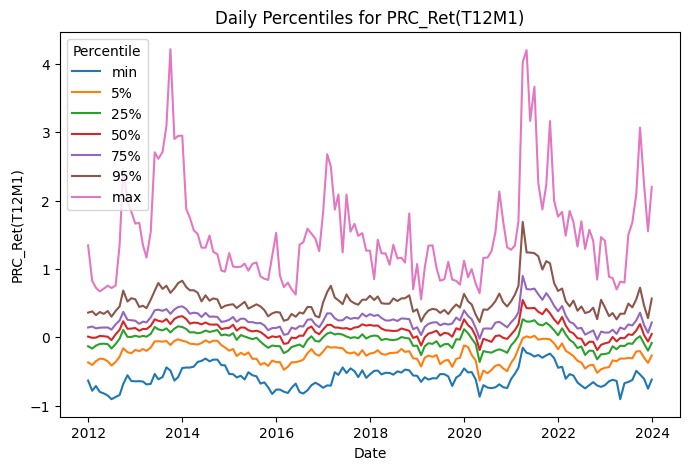

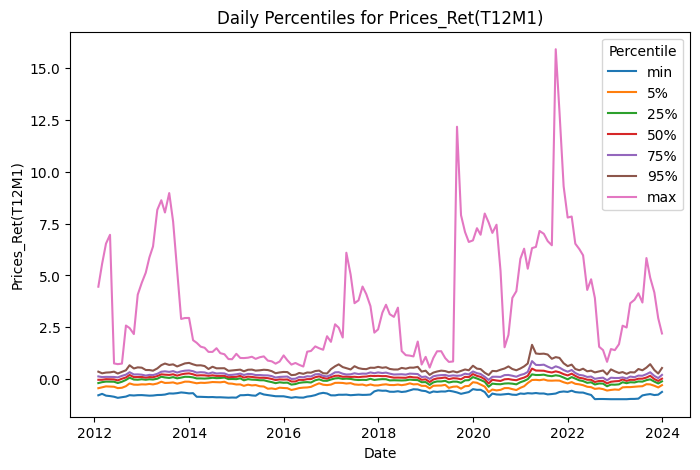

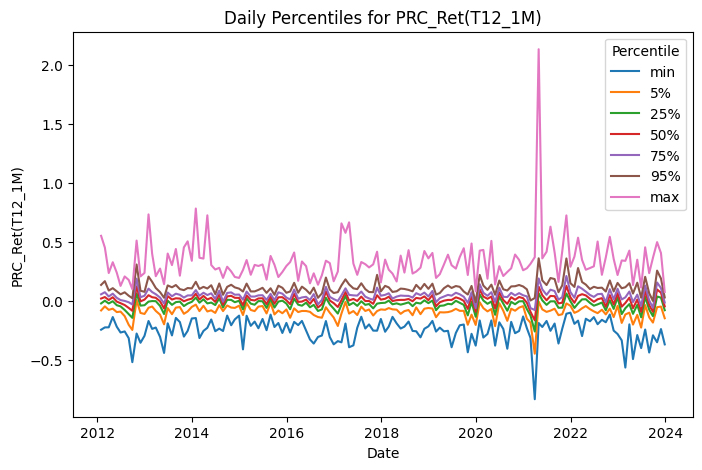

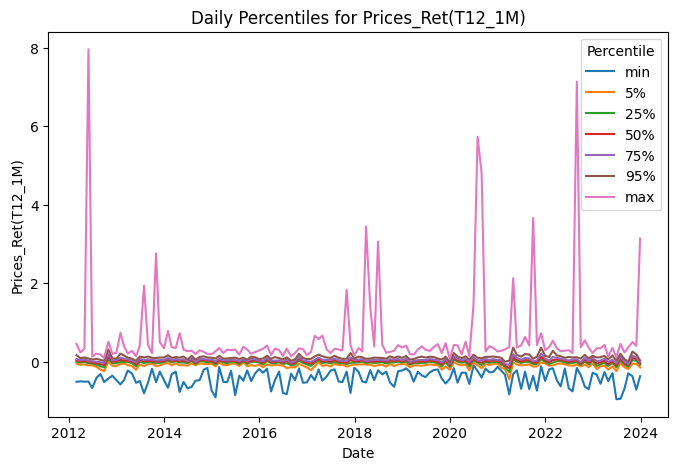

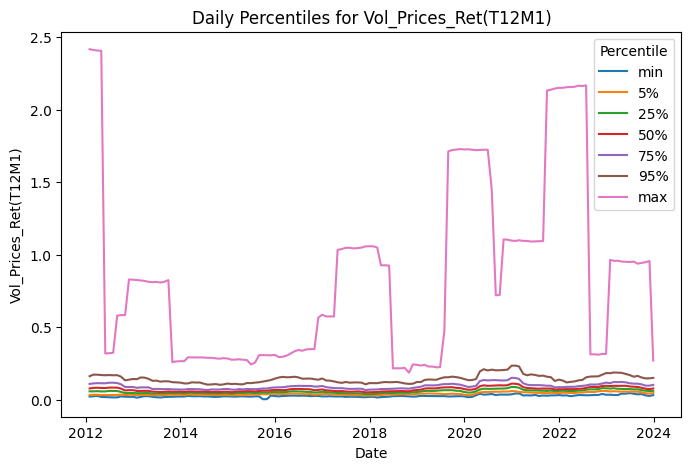

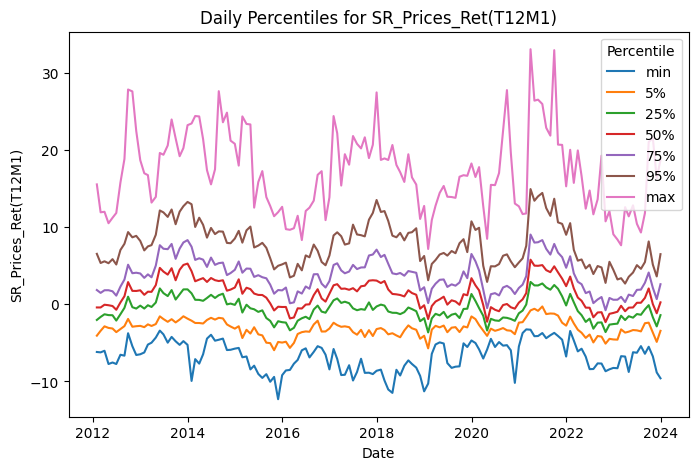

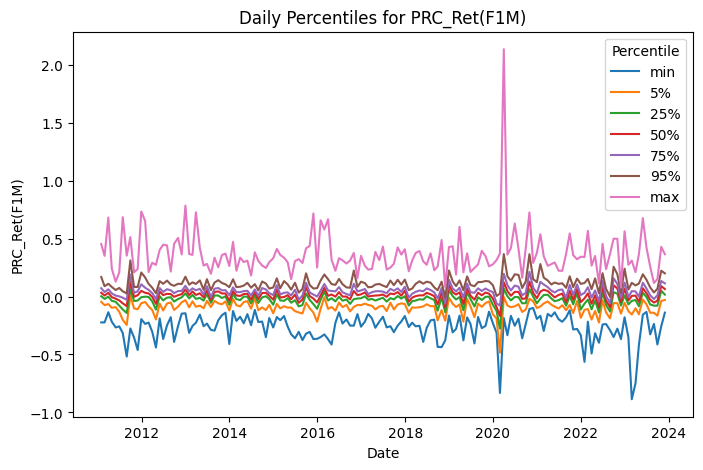

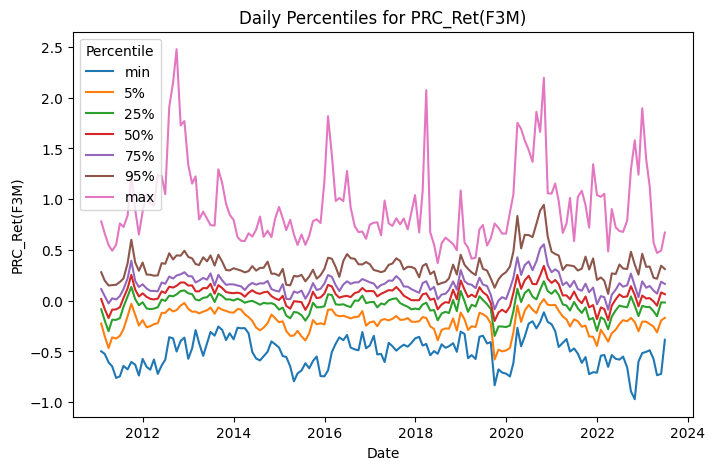

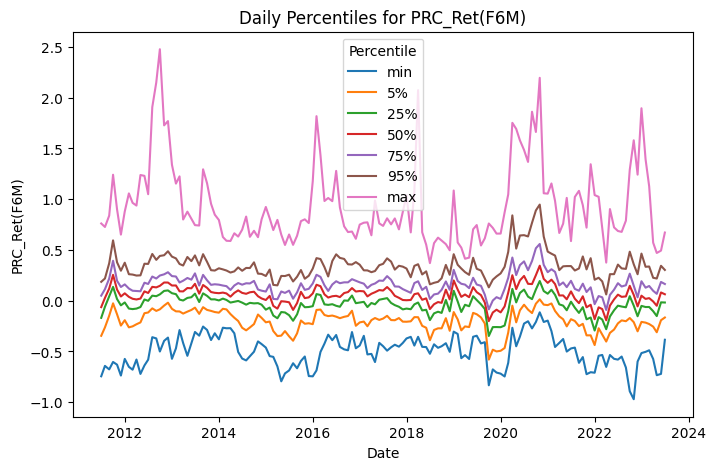

In [53]:
for var in var_list:
    
    percentiles_df = df.groupby('date')[var].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).reset_index()
    
    percentiles_df = percentiles_df[['date', 'min', '5%', '25%', '50%', '75%', '95%', 'max']]
    
    melted_df = percentiles_df.melt(id_vars=['date'], var_name='Percentile', value_name=var)
    
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=melted_df, x='date', y=var, hue='Percentile')
    plt.title(f'Daily Percentiles for {var}')
    plt.xlabel('Date')
    plt.ylabel(var)
    plt.legend(title='Percentile')
    plt.show()

### Q7 Fama-McBeth Cross-sectional Regression

#### a)

In [54]:
# Period: October 31st 2019 to November 30th 2019
# dependent var: PRC_Ret(F1M)
# independent variables: PRC_Ret(T12M1)

import statsmodels.api as sm

date = df.index[df.index <= '2019-11-30'].max()
nov_2019_df = df.loc[date].copy()
nov_2019_df.dropna(inplace=True)

X = sm.add_constant(nov_2019_df['PRC_Ret(T12M1)'])
Y = nov_2019_df['PRC_Ret(F1M)']
display(nov_2019_df.shape)
model = sm.OLS(Y, X).fit()
print(model.summary())


(472, 17)

                            OLS Regression Results                            
Dep. Variable:           PRC_Ret(F1M)   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     17.26
Date:                Sun, 07 Apr 2024   Prob (F-statistic):           3.87e-05
Time:                        23:53:48   Log-Likelihood:                 749.89
No. Observations:                 472   AIC:                            -1496.
Df Residuals:                     470   BIC:                            -1487.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0325      0.003     12.

Based on the OLS regression results you've provided, let's interpret the coefficient for PRC_Ret(T12M1) in the context of predicting one-month forward returns (PRC_Ret(F1M)) for November 2019:

Coefficient Interpretation
const Coefficient (Intercept): The constant term is 0.0325, indicating that when PRC_Ret(T12M1) is 0 (i.e., no momentum from the past 12 months excluding the most recent month), the expected one-month forward return is 3.25%. This can be thought of as the average level of forward returns when there's no momentum effect from the specified period.

PRC_Ret(T12M1) Coefficient: The coefficient for PRC_Ret(T12M1) is -0.0441. This coefficient is statistically significant (p < 0.0001), as indicated by the very low p-value. The negative sign of the coefficient suggests that there's an inverse relationship between past 12-month returns, excluding the most recent month, and the one-month forward return. Specifically, a 1% increase in PRC_Ret(T12M1) is associated with a 0.0441% decrease in the one-month forward return (PRC_Ret(F1M)).

Statistical Significance
The F-statistic is 17.26 with a p-value of 3.87e-05, indicating that the model is statistically significant. This means that there's strong evidence that at least one of the predictors in the model has a non-zero coefficient.

The t-statistic for PRC_Ret(T12M1) is -4.155, with a p-value < 0.0001, providing strong evidence against the null hypothesis (which would state that the coefficient equals zero), and hence, indicating that PRC_Ret(T12M1) is a significant predictor of PRC_Ret(F1M).

R-squared
The R-squared value is 0.035, meaning that about 3.5% of the variability in the one-month forward returns can be explained by the past 12-month returns (excluding the most recent month). Although the model is statistically significant, the R-squared value suggests that the model explains a relatively small portion of the variance in forward returns.
Economic Interpretation
Economically, the negative coefficient for PRC_Ret(T12M1) suggests that a momentum strategy based on the past 12 months (excluding the most recent month) may not be effective over this specific period; in fact, it might indicate a reversal effect, where stocks that performed well over the past year (excluding the most recent month) tend to perform slightly worse in the following month.

Explaining to a Layperson
To an educated layperson, you might explain: "Our analysis of stock returns shows that looking at how well stocks did in the past year doesn't help us predict next month's winners. In fact, stocks that rose the most last year tended to do slightly worse the following month. This suggests that picking stocks based solely on their past momentum might not be a reliable strategy, at least over the period we studied."

Conclusion
The results indicate a statistically significant inverse relationship between past returns and future returns for the period analyzed. However, the low R-squared value suggests that PRC_Ret(T12M1) alone does not strongly predict future returns, and other factors not included in this model may also influence future returns. These findings highlight the complexity of financial markets and the difficulty in predicting stock returns based on past performance alone.

#### b) Cross-sectinal regression

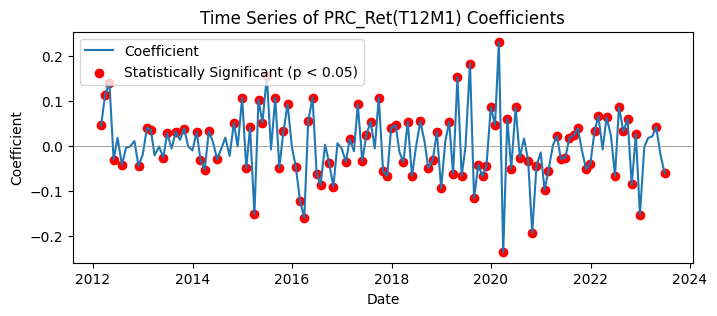

In [55]:
all_df = df.copy()
all_df.dropna(inplace=True)

dates = all_df.index.unique()
coefficients = []
p_values = []


for period in dates:
    period_data = all_df.loc[period]
    
    X = sm.add_constant(period_data['PRC_Ret(T12M1)'])
    Y = period_data['PRC_Ret(F1M)']
        
    model = sm.OLS(Y, X).fit()
    coefficients.append(model.params['PRC_Ret(T12M1)'])
    p_values.append(model.pvalues['PRC_Ret(T12M1)'])

results_df = pd.DataFrame({'Date': dates, 'Coefficient': coefficients, 'P-Value': p_values})

plt.figure(figsize=(8, 3))
plt.plot(results_df['Date'], results_df['Coefficient'], label='Coefficient')
plt.axhline(0, color='grey', lw=0.5) 
plt.title('Time Series of PRC_Ret(T12M1) Coefficients')
plt.xlabel('Date')
plt.ylabel('Coefficient')

significant_periods = results_df[results_df['P-Value'] < 0.05]
plt.scatter(significant_periods['Date'], significant_periods['Coefficient'], color='red', label='Statistically Significant (p < 0.05)')

plt.legend()
plt.show()


Interpretation of the Coefficient for November 2019
The coefficient for PRC_Ret(T12M1) in November 2019 is -0.0441, with a p-value of 3.87e-05, indicating statistical significance. This negative coefficient suggests that stocks with higher returns over the past 12 months (excluding the most recent month) tended to have lower returns in the following month. In other words, there's a short-term reversal in the momentum; stocks that were previously winning (in terms of returns) are likely to underperform in the immediate next period. The R-squared of 0.035 indicates that past momentum explains only 3.5% of the variance in future returns for this particular month, suggesting other factors also play a significant role in determining future returns.

Analysis of the Entire Sample
The time series plot of coefficients over the entire sample period reveals fluctuations in the predictive power of PRC_Ret(T12M1) over time. There are periods where the coefficient is significantly positive, indicating periods where momentum strategies (buying past winners and selling past losers) would have performed well. Conversely, there are also periods with significantly negative coefficients, indicating short-term reversals where momentum strategies would underperform.

The presence of both significantly positive and negative coefficients over the sample indicates that the effectiveness of a momentum strategy can vary greatly over time. This variation could be influenced by market conditions, investor sentiment, economic factors, or other variables not captured by the model.

Economic and Statistical Interpretation
Economically, this analysis suggests that momentum investing is not universally effective across all periods. The strategy's effectiveness depends on the market environment, with some periods showing that past winners continue to outperform (momentum) and other periods indicating that past winners underperform (reversal).

Statistically, the variation in the significance and direction of the coefficient across different periods suggests that momentum's effectiveness is not stable over time. This instability makes it challenging to apply a one-size-fits-all momentum strategy across all market conditions.

Conclusion and Explanation to a Layperson
Momentum investing, which involves buying stocks that have performed well in the past and selling those that have performed poorly, doesn't always work. Our analysis shows that sometimes, stocks that did well in the past year don't continue to do so in the following month. This pattern changes over time; in some months, momentum investing might work, while in others, it might not.

Imagine surfing: catching a wave (or investing in a stock) at the right time can lead to a great ride (return), but conditions change, and not every wave is perfect. Sometimes, what seemed like a promising wave (a past winner) might suddenly lose its momentum, leading to a less successful ride. Therefore, relying solely on past performance is like trying to predict the ocean's behavior by looking at yesterday's waves.

Observations Across Time
Significant periods, such as those with particularly high positive or negative coefficients, highlight times when momentum strategies either performed exceptionally well or poorly. These standout periods could be associated with specific market events or economic conditions that influenced investor behavior and market dynamics.

In conclusion, while momentum strategies can be part of an investor's toolkit, their application requires careful consideration of current and historical market conditions. There's no guarantee that past winners will continue their streak, and as seen, the strategy's effectiveness can change significantly over time.

In [56]:
all_df.describe()

,permno,price,shrout,prc,mcap,Price_Ret(T1),PRC_Ret(T12),Prices_Ret(T12),PRC_Ret(T12M1),Prices_Ret(T12M1),PRC_Ret(T12_1M),Prices_Ret(T12_1M),Vol_Prices_Ret(T12M1),SR_Prices_Ret(T12M1),PRC_Ret(F1M),PRC_Ret(F3M),PRC_Ret(F6M)
count,64555.000000,64555.000000,6.455500e+04,64555.000000,6.455500e+04,64555.000000,64555.000000,64555.000000,64555.000000,64555.000000,64555.000000,64555.000000,64555.000000,64555.000000,64555.000000,64555.000000,64555.000000
mean,55484.229277,114.063349,6.302194e+05,0.011389,4.944994e+07,0.009318,0.137053,0.109618,0.124722,0.099791,0.010824,0.008812,0.079170,1.788010,0.011327,0.065114,0.065114
std,28833.326109,203.599752,1.120576e+06,0.083077,1.122484e+08,0.100292,0.308243,0.395039,0.290906,0.371272,0.081308,0.102972,0.063716,3.961284,0.083187,0.201642,0.201642
min,10104.000000,2.050000,3.196000e+03,-0.832263,1.089831e+06,-0.955823,-0.898914,-0.974808,-0.905043,-0.971920,-0.832263,-0.955823,0.014040,-12.302007,-0.832263,-0.970718,-0.970718
25%,24205.000000,42.190000,1.640870e+05,-0.034227,1.157675e+07,-0.036367,-0.046561,-0.081064,-0.046257,-0.077703,-0.033177,-0.035356,0.051147,-1.039211,-0.034320,-0.052624,-0.052624
50%,60628.000000,70.530000,3.102350e+05,0.012217,2.125028e+07,0.010157,0.117545,0.085291,0.107443,0.078568,0.012047,0.009986,0.068588,1.210705,0.012218,0.060393,0.060393
75%,82775.000000,120.200000,5.995445e+05,0.056143,4.514407e+07,0.054233,0.287099,0.256062,0.266871,0.239402,0.054664,0.052729,0.092550,4.004333,0.056037,0.172034,0.172034
max,93436.000000,6350.620120,1.710254e+07,2.135168,3.035217e+09,7.139768,4.679823,15.626183,4.215091,15.919743,2.135168,7.965142,2.411869,33.028226,2.135168,2.476854,2.476854


### 8 a) univariate regressions

#### Price_Ret(T1); PRC; PRC_Ret(T12); Prices_Ret(T12); PRC_Ret(T12M1); Prices_Ret(T12M1); PRC_Ret(T12_1M); Prices_Ret(T12_1M); and SR_Prices_Ret(T12M1)

In [57]:
def cross_sectional_regression(df, independent_var, dependent_var):
    dates = df.index.unique()
    coefficients = []
    p_values = []

    for period in dates:
        period_data = df.loc[period]
        
        X = sm.add_constant(period_data[independent_var])
        Y = period_data[dependent_var]
            
        model = sm.OLS(Y, X).fit()
        coefficients.append(model.params[independent_var])
        p_values.append(model.pvalues[independent_var])

    results_df = pd.DataFrame({'Date': dates, 'Coefficient': coefficients, 'P-Value': p_values})

    plt.figure(figsize=(8, 3))
    plt.plot(results_df['Date'], results_df['Coefficient'], label='Coefficient')
    plt.axhline(0, color='grey', lw=0.5) 
    plt.title(f'Time Series of {independent_var} Coefficients')
    plt.xlabel('Date')
    plt.ylabel('Coefficient')

    significant_periods = results_df[results_df['P-Value'] < 0.05]
    plt.scatter(significant_periods['Date'], significant_periods['Coefficient'], color='red', label='Statistically Significant (p < 0.05)')

    plt.legend()
    plt.tight_layout()
    plt.show()

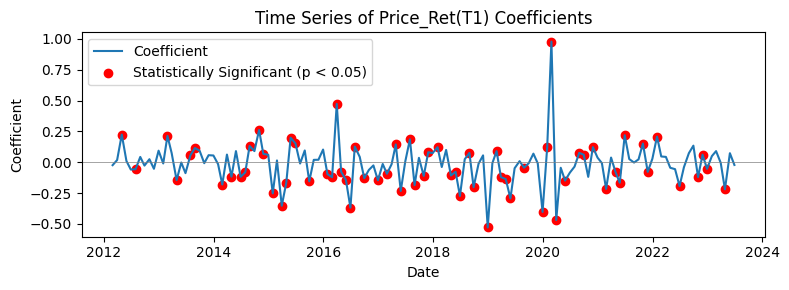

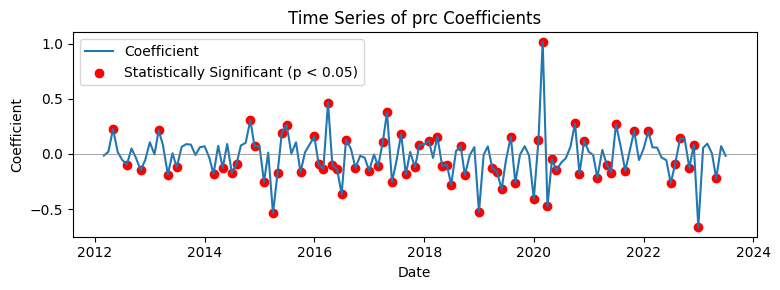

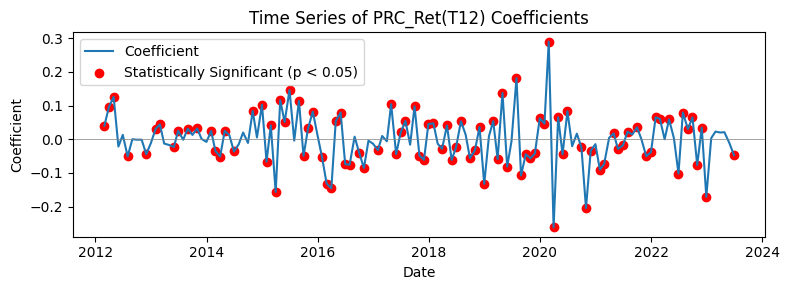

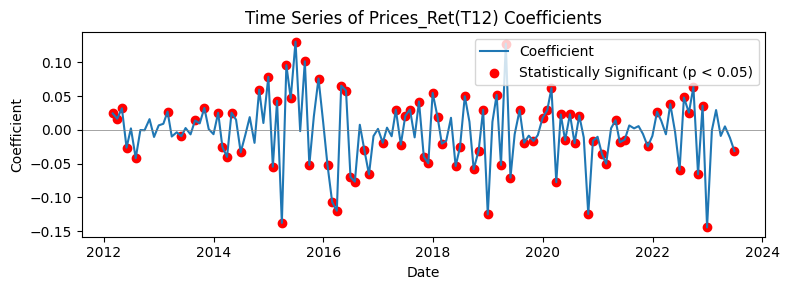

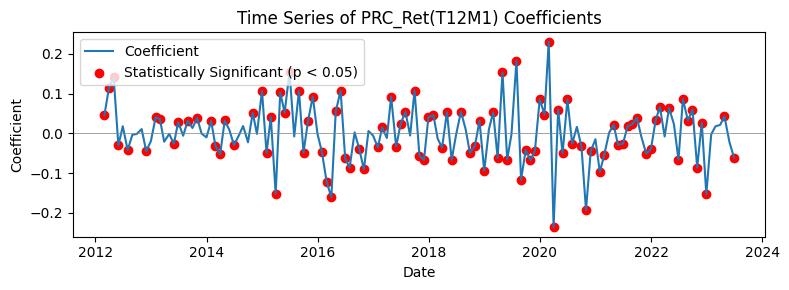

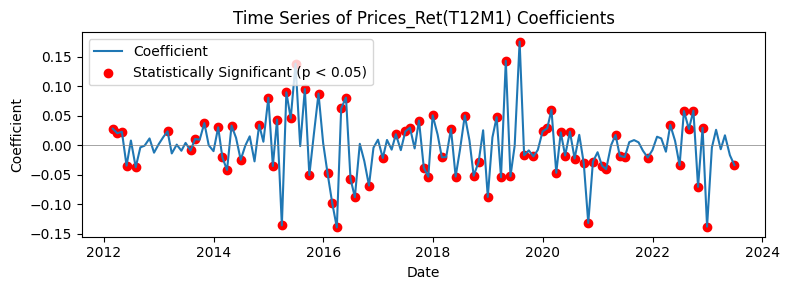

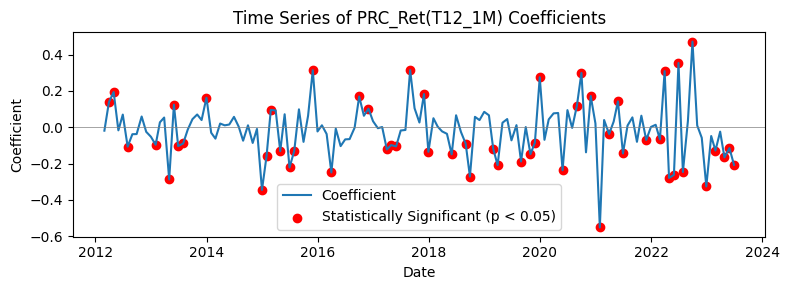

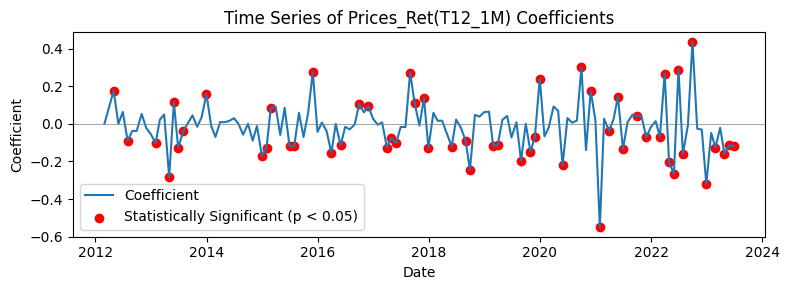

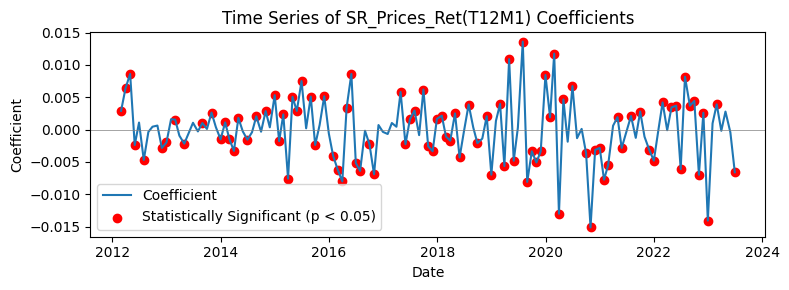

In [58]:
cross_sectional_regression(all_df, 'Price_Ret(T1)', 'PRC_Ret(F1M)')
cross_sectional_regression(all_df, 'prc', 'PRC_Ret(F1M)')
cross_sectional_regression(all_df, 'PRC_Ret(T12)', 'PRC_Ret(F1M)')
cross_sectional_regression(all_df, 'Prices_Ret(T12)', 'PRC_Ret(F1M)')
cross_sectional_regression(all_df, 'PRC_Ret(T12M1)', 'PRC_Ret(F1M)')
cross_sectional_regression(all_df, 'Prices_Ret(T12M1)', 'PRC_Ret(F1M)')
cross_sectional_regression(all_df, 'PRC_Ret(T12_1M)', 'PRC_Ret(F1M)')
cross_sectional_regression(all_df, 'Prices_Ret(T12_1M)', 'PRC_Ret(F1M)')
cross_sectional_regression(all_df, 'SR_Prices_Ret(T12M1)', 'PRC_Ret(F1M)')

#### 8 b) Multivariate Regression:
i.	Price_Ret(T1) and Prices_Ret(T12M1)

ii.	PRC and PRC_Ret(T12M1)

iii. PRC and Prices_Ret(T12)

iv.	PRC and SR_Prices_Ret(T12M1)


In [59]:
def multivariate_cross_sectional_regression(df, independent_var_list, dependent_var):
    dates = df.index.unique()
    results = []

    for period in dates:
        period_data = df.loc[period]
        
        X = sm.add_constant(period_data[independent_var_list])
        Y = period_data[dependent_var]
            
        model = sm.OLS(Y, X).fit()
        for var in independent_var_list:
            results.append({
                'Date' : period,
                'Variable' : var,
                'Coefficient' : model.params.get(var, 0),
                'p-value' : model.pvalues.get(var, 1)
            })

    results_df = pd.DataFrame(results)

    fig, axs = plt.subplots(1, len(independent_var_list), figsize=(16, 3))
    
    for i, var in enumerate(independent_var_list):
        var_data = results_df[results_df['Variable'] == var]
        axs[i].plot(var_data['Date'], var_data['Coefficient'], label='Coefficient')
        axs[i].axhline(0, color='grey', lw=0.5)
        axs[i].set_title(f'Time Series of {var} Coefficients')
        axs[i].set_xlabel('Date')
        axs[i].set_ylabel('Coefficient')
        
        significant_periods = var_data[var_data['p-value'] < 0.05]
        axs[i].scatter(significant_periods['Date'], significant_periods['Coefficient'], color='red', label='Statistically Significant (p < 0.05)')
        
        axs[i].legend()
    
    plt.tight_layout()
    plt.show()

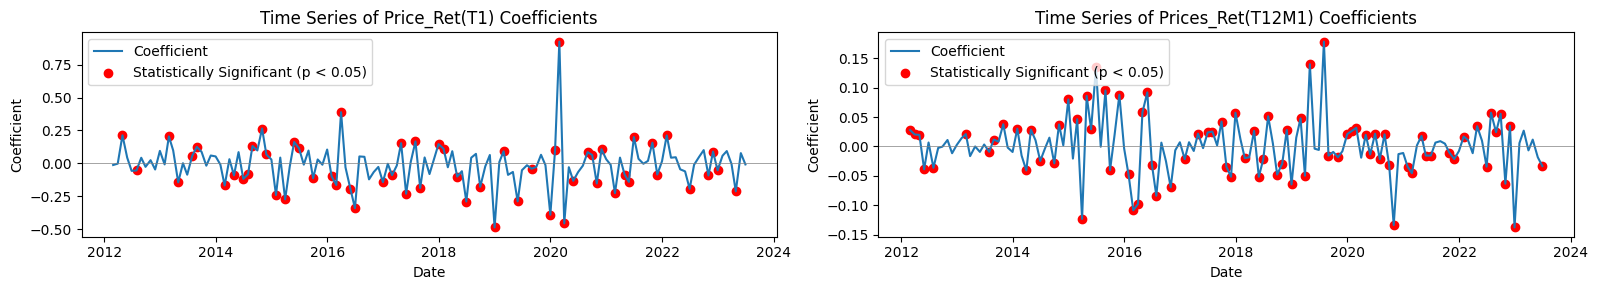

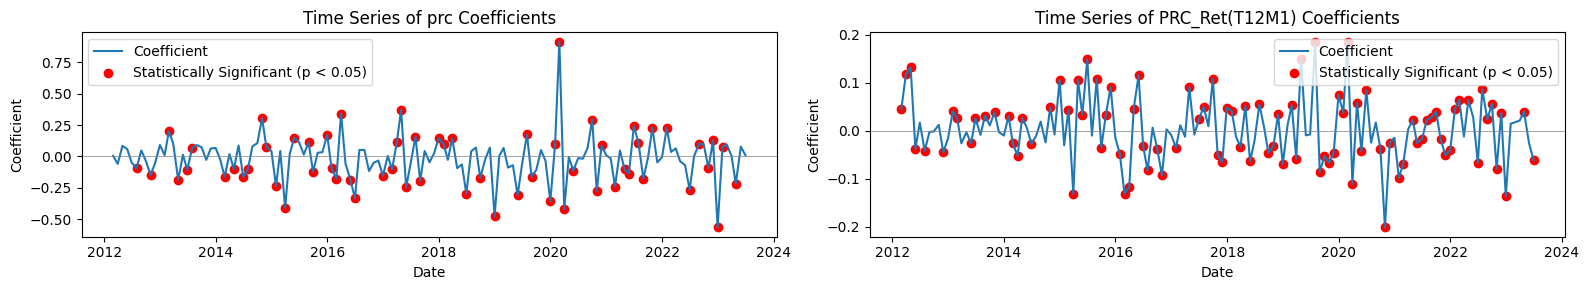

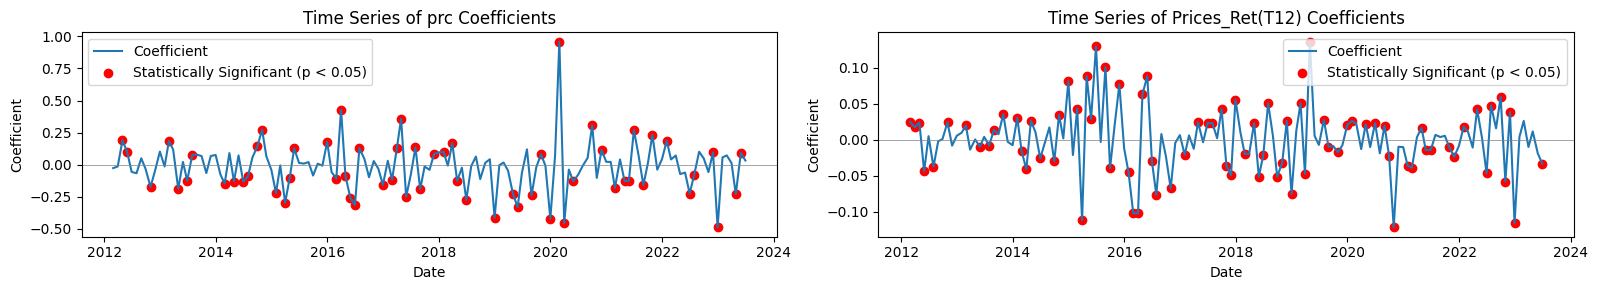

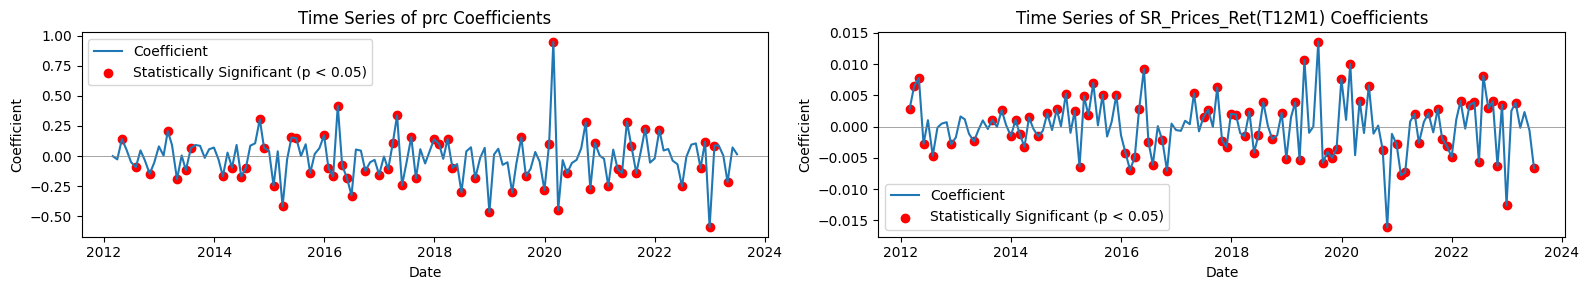

In [60]:
multivariate_cross_sectional_regression(all_df, ['Price_Ret(T1)', 'Prices_Ret(T12M1)'], 'PRC_Ret(F1M)')

multivariate_cross_sectional_regression(all_df, ['prc', 'PRC_Ret(T12M1)'], 'PRC_Ret(F1M)')

multivariate_cross_sectional_regression(all_df, ['prc', 'Prices_Ret(T12)'], 'PRC_Ret(F1M)')

multivariate_cross_sectional_regression(all_df, ['prc', 'SR_Prices_Ret(T12M1)'], 'PRC_Ret(F1M)')

### 9 Cross-sectional regression:
independent variables is PRC_Ret(T12M1)

dependent variables: PRC_Ret(F3M) and PRC_Ret(F6M). 

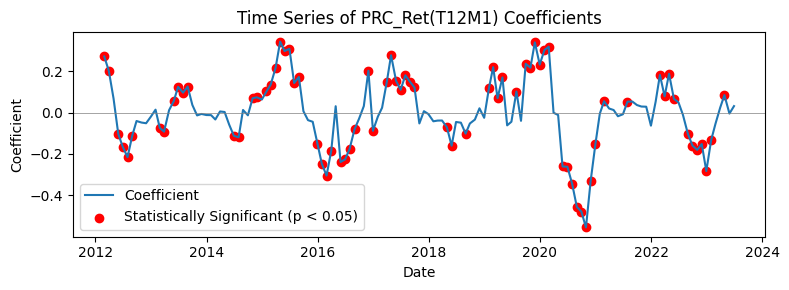

In [61]:
cross_sectional_regression(all_df, 'PRC_Ret(T12M1)', 'PRC_Ret(F3M)')

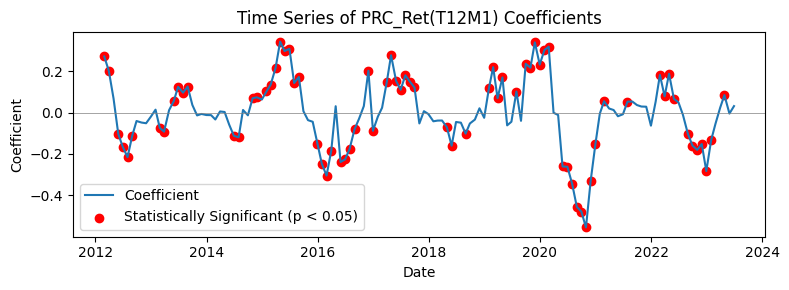

In [62]:
cross_sectional_regression(all_df, 'PRC_Ret(T12M1)', 'PRC_Ret(F6M)')